Column name:  protocol_type
Column name:  service
Column name:  flag
+--------------------+---+
|            features|  y|
+--------------------+---+
|(41,[1,2,4,5,11,2...|1.0|
|(41,[1,2,4,5,11,2...|1.0|
|(41,[1,2,4,5,11,2...|1.0|
|(41,[1,2,4,5,11,2...|1.0|
|(41,[1,2,4,5,11,2...|1.0|
|(41,[1,2,4,5,11,2...|1.0|
|(41,[1,2,4,5,11,2...|1.0|
|(41,[1,2,4,5,11,2...|1.0|
|(41,[1,2,4,5,11,2...|1.0|
|(41,[1,2,4,5,9,11...|1.0|
|(41,[1,2,4,5,11,2...|1.0|
|(41,[1,2,4,5,11,2...|1.0|
|(41,[1,2,4,5,11,2...|1.0|
|(41,[1,2,4,5,11,2...|1.0|
|(41,[1,2,4,5,11,2...|1.0|
|(41,[1,2,4,5,11,2...|1.0|
|(41,[1,2,4,5,11,2...|1.0|
|(41,[1,2,4,5,11,2...|1.0|
|(41,[1,2,4,5,11,2...|1.0|
|(41,[1,2,4,5,11,2...|1.0|
+--------------------+---+
only showing top 20 rows

+---+--------------------+----------+
|  y|         probability|prediction|
+---+--------------------+----------+
|1.0|[0.06884192434731...|       1.0|
|1.0|[0.07120327693362...|       1.0|
|1.0|[0.07363922095105...|       1.0|
|1.0|[0.07540792940115...|   

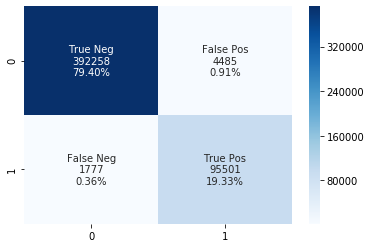

In [6]:
import os
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import SQLContext
from pyspark.sql.session import SparkSession
from pyspark.ml.feature import VectorAssembler

from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import FloatType
from pyspark.sql.types import StringType
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import IntegerType

from sklearn import metrics
import numpy as np
import seaborn as sns


# CREATE SPARK SESSION
spark = SparkSession.builder.master("local").appName("Kdd cup 1999").getOrCreate()

# build the schema to load dataframe.
columnames = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
      "hot", "num_failed_logins", "logged_in", "num_compromised",
      "root_shell", "su_attempted", "num_root", "num_file_creations",
      "num_shells", "num_access_files", "num_outbound_cmds",
      "is_host_login", "is_guest_login", "count", "srv_count",
      "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
      "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
      "dst_host_count", "dst_host_srv_count",
      "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
      "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
      "dst_host_serror_rate", "dst_host_srv_serror_rate",
      "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

schemadata = {}

# for i in range(0, len(columnames)):
#     print(columnames[i])

schemadata[columnames[0]] = FloatType()

for i in range(1, 4):
    schemadata[columnames[i]] = StringType()

for i in range(4, 41):
    schemadata[columnames[i]] = FloatType()

schemadata[columnames[41]] = StringType()

schema = StructType([StructField(key, value, False) for key, value in schemadata.items()])

# assembler group all col0...col40 into single column call X
#assembler = VectorAssembler(inputCols=columnames[:-1], outputCol="features")
assembler = VectorAssembler(inputCols=columnames[:-1], outputCol="features")

## TRAINING
training = spark.read.csv("D:\\kddcup.data_10_percent\\kddcup_data", schema = schema)

indexers = {}

# Convert non numeric attributs to numeric for testing dataset
for i in range(1, 4):
    name = columnames[i]
    print("Column name: ", name)
    indexers[name] = StringIndexer(inputCol=name, outputCol="_"+name)
    training = indexers[name].fit(training).transform(training)
    training = training.drop(name)
    training = training.withColumnRenamed("_"+name, name)

# training.printSchema()
training = assembler.transform(training) 

# Keep X and y only
#training.select(training.label).show(truncate = False)
training = training.withColumn("y", (training.label=="normal.").cast(FloatType()))
#training.printSchema()
training = training.select("features", "y")
#training.printSchema()
training.show()

# Logistic Regression
lr = LogisticRegression(maxIter=100, regParam=0.03, elasticNetParam=0.8, featuresCol="features", labelCol="y")

# Learn a LogisticRegression model using parameters in lr
model = lr.fit(training)

# ## TESTING
testing = spark.read.csv("D:\\kddcup.data_10_percent\\kddcup_data", schema = schema)

# Convert non numeric attributs to numeric for testing dataset
for i in range(1, 4):
    name = columnames[i]
    indexers[name] = StringIndexer(inputCol=name, outputCol="_"+name)
    testing = indexers[name].fit(testing).transform(testing)
    testing = testing.drop(name)
    testing = testing.withColumnRenamed("_"+name, name)

testing = assembler.transform(testing)

# Keep X and y only
#testing.select().show(truncate = False)
testing = testing.withColumn("y", (testing.label=="normal.").cast(FloatType()))
#testing.printSchema()
testing = testing.select("features", "y")
# testing.printSchema()
# testing.show()

# Make prediction
prediction = model.transform(testing).select("features", "y", "probability", "prediction")

# Show prediction
prediction.select("y", "probability", "prediction").show()

# show some Statistics
print("Show some statistics: \n")
fraud = prediction.filter(prediction.y == 0).count()
fraud_prediction = prediction.filter(prediction.y == 0).filter(prediction.prediction == 0).count()

normal = prediction.filter(prediction.y == 1).count()
normal_prediction = prediction.filter(prediction.y == 1).filter(prediction.prediction == 1).count()

print("Number of fraud connections : " + str(fraud) + " Number of fraud prediction connections : " + str(fraud_prediction))
print("Number of normal connections : " + str(normal) + " Number of normal prediction connections : " + str(normal_prediction))

print("accuracy on fraud connection: " + str(fraud_prediction) + " / " + str(fraud) + " = " + str(float(fraud_prediction) / fraud))
print("accuracy on normal connection: " + str(normal_prediction) + " / " + str(normal) + " = " + str(float(normal_prediction) / normal))

y_true = prediction.select(['y']).collect()
y_pred = prediction.select(['prediction']).collect()

cmat = metrics.confusion_matrix(y_true, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cmat.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cmat.flatten()/np.sum(cmat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cmat, annot=labels, fmt='', cmap='Blues')

print('TP - True Negative {}'.format(cmat[0,0]))
print('FP - False Positive {}'.format(cmat[0,1]))
print('FN - False Negative {}'.format(cmat[1,0]))
print('TP - True Positive {}'.format(cmat[1,1]))
print('Accuracy Rate: {}'.format(np.divide(np.sum([cmat[0,0],cmat[1,1]]),np.sum(cmat))))
print('Misclassification Rate: {}'.format(np.divide(np.sum([cmat[0,1],cmat[1,0]]),np.sum(cmat))))